<a href="https://colab.research.google.com/github/nguyenhongquy/semplaus/blob/main/ML_approach_rf_dt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Constants

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* PAP Dataset Path

In [ ]:
BASE_DIR_PAP = '/content/drive/MyDrive/semantic plausibility/datasets/pap/train-dev-test-split/binary'
PWD = '/content/drive/MyDrive/semantic plausibility'

In [ ]:
TRAIN_PAP = 'train.csv'
DEV_PAP = 'dev.csv'
TEST_PAP = 'test.csv'

* PEP-3K Dataset Path

In [ ]:
BASE_DIR_PEP = '/content/drive/MyDrive/semantic plausibility/datasets/pep-3k/train-dev-test-split'

In [ ]:
TRAIN_PEP = 'train.csv'
DEV_PEP = 'dev.csv'
TEST_PEP = 'test.csv'

* Noun_bin_annotations File Path

In [ ]:
noun_bin_annotations_path = '/content/drive/MyDrive/semantic plausibility/datasets/pep-3k/additional-resources/wang-et-al-2018/data/noun_bin_annotations.tar.gz'

* ADEPT Dataset Path

In [ ]:
BASE_DIR_ADEPT = '/content/drive/MyDrive/semantic plausibility/datasets/adept/train-dev-test-split'

In [ ]:
TRAIN_ADEPT = 'train.json'
DEV_ADEPT = 'val.json'
TEST_ADEPT = 'test.json'

* Decision Tree Picture Store Path

In [ ]:
decision_tree_store_path = "/content/drive/MyDrive/semantic plausibility"

In [ ]:
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, accuracy_score,roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint, uniform
import numpy as np
import pandas as pd
import tarfile
import os
import pickle
import json
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import graphviz

# ML Approach -- Random Forest Model

### Needed Functions

In [ ]:
def read_csv(base_dir, split):

    # Read csv training data
    df = pd.read_csv(f'{base_dir}/{split}')

    # Extract text data
    texts = df['text']

    # Tokenize the sentences into words
    df['tokenize'] = df['text'].apply(lambda x: x.split())

    return df['tokenize'], df['label']

In [ ]:
def create_word2vec_model(sentences, vector_size=100, window=2, min_count=1):

    word2vec_model = Word2Vec(sentences=sentences, vector_size=vector_size, window=window, min_count=min_count)
    word2vec_words = set(word2vec_model.wv.index_to_key)

    return word2vec_model, word2vec_words

In [ ]:
def compute_sentence_vectors(X, word2vec_model):

    sentence_vectors = []

    for sentence in X:
        word_vectors = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
        if word_vectors:
            sentence_vector = sum(word_vectors) / len(word_vectors)
        else:
            sentence_vector = np.zeros(word2vec_model.vector_size)
        sentence_vectors.append(sentence_vector)

    return sentence_vectors

In [ ]:
def train_random_forest(X_train, y_train, params=None):

    if params:
        rf = RandomForestClassifier(**params)
    else:
        rf = RandomForestClassifier()

    rf_model = rf.fit(X_train, y_train.values.ravel())

    return rf_model

In [ ]:
def hyperparameter_tuning(X_train, y_train, X_dev, y_dev, param_grid):

    rf = RandomForestClassifier()

    # Use 3-fold-cross-validation
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_dev, y_dev)

    best_params = grid_search.best_params_

    return best_params

In [ ]:
def evaluate_model_rf(X_eval, y_eval, word2vec_model, rf_model):

    X_eval_vectors = compute_sentence_vectors(X_eval, word2vec_model)
    y_pred = rf_model.predict(X_eval_vectors)

    precision = precision_score(y_eval, y_pred)
    recall = recall_score(y_eval, y_pred)
    accuracy = (y_pred == y_eval).sum() / len(y_pred)

    print(f'Precision: {precision:.3f} / Recall: {recall:.3f} / Accuracy: {accuracy:.3f}')

    fpr, tpr, thresholds = roc_curve(y_eval, y_pred)
    auc_score = auc(fpr, tpr)

    print(f'AUC: {auc_score:.3f}')

## 1. In PAP Dataset

### Data Loading and Preprocessing
* Load dataset splits
* Tokenization

In [ ]:
X_train_PAP, y_train_PAP = read_csv(BASE_DIR_PAP, TRAIN_PAP)
X_dev_PAP, y_dev_PAP = read_csv(BASE_DIR_PAP, DEV_PAP)
X_test_PAP, y_test_PAP = read_csv(BASE_DIR_PAP, TEST_PAP)

In [ ]:
X_train_PAP

0                       [event, occurs, year]
1                    [tortoise, brings, limb]
2           [headliner, overpowers, function]
3                    [county, receives, hour]
4       [traveler, acknowledges, recognition]
                        ...                  
1723         [classification, hauls, slavery]
1724                  [library, needs, space]
1725           [analysis, constrains, theory]
1726                     [row, elicits, game]
1727                [consumer, pokes, vision]
Name: tokenize, Length: 1728, dtype: object

In [ ]:
y_train_PAP

0       1
1       1
2       1
3       0
4       1
       ..
1723    1
1724    1
1725    1
1726    1
1727    1
Name: label, Length: 1728, dtype: int64

### Word Embedding and Sentence Vector Computation
* Word Embedding
* Computing Sentence Vectors

In [ ]:
# Word2Vec Model Creation
word2vec_model_PAP, word2vec_words_PAP = create_word2vec_model(X_train_PAP)

In [ ]:
# Compute Sentence Vectors
X_train_vectors_PAP = compute_sentence_vectors(X_train_PAP, word2vec_model_PAP)
X_dev_vectors_PAP = compute_sentence_vectors(X_dev_PAP, word2vec_model_PAP)
X_test_vectors_PAP = compute_sentence_vectors(X_test_PAP, word2vec_model_PAP)

### 1.1 Random Forest Model Training, without hyperparameter tuning

* Train Random Forest
* Evaluation


In [ ]:
# Training Random Forest Model
rf_regular_model_PAP = train_random_forest(X_train_vectors_PAP, y_train_PAP)

In [ ]:
# Evaluation on Dev and Test Sets
print("Evaluation of randomforest model without hyperparameter tuning in PAP dataset.")

print("\nDev dataset:")
evaluate_model_rf(X_dev_PAP, y_dev_PAP, word2vec_model_PAP, rf_regular_model_PAP)

print("\nTest dataset:")
evaluate_model_rf(X_test_PAP, y_test_PAP, word2vec_model_PAP, rf_regular_model_PAP)

Evaluation of randomforest model without hyperparameter tuning in PAP dataset.

Dev dataset:
Precision: 0.723 / Recall: 0.864 / Accuracy: 0.667
AUC: 0.521

Test dataset:
Precision: 0.721 / Recall: 0.955 / Accuracy: 0.704
AUC: 0.518


### 1.2 Random Forest Model Training, with  hyperparameter tuning

* Hyperparameter Tuning
* Train Random Forest
* Evaluation

In [ ]:
# Get the tuned hyperparameters
param_grid_rf_PAP = {

    # The number of trees in the forest (ensemble)
    'n_estimators': [50, 100, 150],

    # The maximum depth of each tree in the forest
    'max_depth': [10, 20, 30],

    # The minimum number of samples required to split an internal node
    'min_samples_split': [2, 5, 8],

    # This parameter specifies the minimum number of samples required to be at a leaf node
    'min_samples_leaf': [1, 2, 5],

    # The number of features to consider when looking for the best split
    'max_features': ['auto', 'sqrt', 'log2']
}
rf_best_params_PAP = hyperparameter_tuning(X_train_vectors_PAP, y_train_PAP, X_dev_vectors_PAP, y_dev_PAP, param_grid_rf_PAP)
print("Best Hyperparameters:", rf_best_params_PAP)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best Hyperparameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 100}


In [ ]:
# Training with Best Hyperparameters
rf_tune_model_PAP = train_random_forest(X_train_vectors_PAP, y_train_PAP, params=rf_best_params_PAP)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [ ]:
# Evaluation on Dev and Test Sets
print("Evaluation of randomforest model with hyperparameter tuning in PAP dataset.")

print("\nDev dataset:")
evaluate_model_rf(X_dev_PAP, y_dev_PAP, word2vec_model_PAP, rf_tune_model_PAP)

print("\nTest dataset:")
evaluate_model_rf(X_test_PAP, y_test_PAP, word2vec_model_PAP, rf_tune_model_PAP)

Evaluation of randomforest model with hyperparameter tuning in PAP dataset.

Dev dataset:
Precision: 0.715 / Recall: 0.896 / Accuracy: 0.671
AUC: 0.505

Test dataset:
Precision: 0.721 / Recall: 0.974 / Accuracy: 0.713
AUC: 0.519


## 2.1 In PEP Dataset, without Binning by Landmark

### Data Loading and Preprocessing
* Load dataset splits
* Tokenization

In [ ]:
X_train_PEP, y_train_PEP = read_csv(BASE_DIR_PEP, TRAIN_PEP)
X_dev_PEP, y_dev_PEP = read_csv(BASE_DIR_PEP, DEV_PEP)
X_test_PEP, y_test_PEP = read_csv(BASE_DIR_PEP, TEST_PEP)

In [ ]:
X_train_PEP

0              [dog, shake, cat]
1         [student, climb, ship]
2            [pipe, vent, vapor]
3              [chef, burn, air]
4             [boat, crush, air]
                  ...           
2444          [wool, clip, dust]
2445           [rope, hook, pan]
2446        [bag, contain, tree]
2447       [gorilla, bury, leaf]
2448    [sidewalk, curb, wheels]
Name: tokenize, Length: 2449, dtype: object

In [ ]:
y_train_PEP

0       1
1       1
2       1
3       0
4       0
       ..
2444    0
2445    1
2446    0
2447    1
2448    1
Name: label, Length: 2449, dtype: int64

### Word Embedding and Sentence Vector Computation
* Word Embedding
* Computing Sentence Vectors

In [ ]:
# Word2Vec Model Creation
word2vec_model_PEP, word2vec_words_PEP = create_word2vec_model(X_train_PEP)

In [ ]:
# Compute Sentence Vectors
X_train_vectors_PEP = compute_sentence_vectors(X_train_PEP, word2vec_model_PEP)
X_dev_vectors_PEP = compute_sentence_vectors(X_dev_PEP, word2vec_model_PEP)
X_test_vectors_PEP = compute_sentence_vectors(X_test_PEP, word2vec_model_PEP)

### 2.1.1 Random Forest Model Training, without hyperparameter tuning

* Train Random Forest
* Evaluation

In [ ]:
# Training Random Forest Model
rf_regular_model_PEP = train_random_forest(X_train_vectors_PEP, y_train_PEP)

In [ ]:
# Evaluation on Dev and Test Sets
print("Evaluation of randomforest model without hyperparameter tuning in PEP dataset.")

print("\nDev dataset:")
evaluate_model_rf(X_dev_PEP, y_dev_PEP, word2vec_model_PEP, rf_regular_model_PEP)

print("\nTest dataset:")
evaluate_model_rf(X_test_PEP, y_test_PEP, word2vec_model_PEP, rf_regular_model_PEP)

Evaluation of randomforest model without hyperparameter tuning in PEP dataset.

Dev dataset:
Precision: 0.600 / Recall: 0.627 / Accuracy: 0.605
AUC: 0.605

Test dataset:
Precision: 0.574 / Recall: 0.556 / Accuracy: 0.573
AUC: 0.573


### 2.1.2 Random Forest Model Training, with hyperparameter tuning

* Hyperparameter Tuning
* Train Random Forest
* Evaluation

In [ ]:
# Get the best hyperparameters
param_grid_rf_PEP = {

    'n_estimators': [50, 75, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2']

}
rf_best_params_PEP = hyperparameter_tuning(X_train_vectors_PEP, y_train_PEP, X_dev_vectors_PEP, y_dev_PEP,param_grid_rf_PEP)
print("Best Hyperparameters:", rf_best_params_PEP)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 75}


In [ ]:
# Training with Best Hyperparameters
rf_tune_model_PEP = train_random_forest(X_train_vectors_PEP, y_train_PEP, params=rf_best_params_PEP)

In [ ]:
# Evaluation on Dev and Test Sets
print("Evaluation of randomforest model with hyperparameter tuning in PEP dataset.")

print("\nDev dataset:")
evaluate_model_rf(X_dev_PEP, y_dev_PEP, word2vec_model_PEP, rf_tune_model_PEP)

print("\nTest dataset:")
evaluate_model_rf(X_test_PEP, y_test_PEP, word2vec_model_PEP, rf_tune_model_PEP)

Evaluation of randomforest model with hyperparameter tuning in PEP dataset.

Dev dataset:
Precision: 0.560 / Recall: 0.641 / Accuracy: 0.569
AUC: 0.569

Test dataset:
Precision: 0.576 / Recall: 0.569 / Accuracy: 0.577
AUC: 0.577


## 2.2 In PEP Dataset, Combined with Binning by Landmark

### Load noun_bin_annotations dictionary

In [ ]:
# Extract contents of a tar.gz file
def extract_tar_gz(archive_path, extract_directory):

    with tarfile.open(archive_path, 'r:gz') as tar:
        tar.extractall(path=extract_directory)

noun_bin_annotations_dir = 'noun_bin_annotations'
extract_tar_gz(noun_bin_annotations_path, noun_bin_annotations_dir)

In [ ]:
# Read contents of files inside a directory
def load_files(directory):
    file_contents = {}

    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            with open(file_path, 'rb') as f:
                file_contents[file] = pickle.load(f)

    return file_contents

def show_contents(directory):
    files_contents = load_files(directory)
    for file, content in files_contents.items():
        print(f"\nContents of {file}:")
        print(content)

inner_dir = os.path.join(noun_bin_annotations_dir, 'noun_bin_annotations')

loaded_data = load_files(inner_dir)

noun2rigidity = loaded_data['noun2rigidity.p']
noun2masscount = loaded_data['noun2masscount.p']
noun2sentience = loaded_data['noun2sentience.p']
noun2size = loaded_data['noun2size.p']
noun2phase = loaded_data['noun2phase.p']
noun2weight = loaded_data['noun2weight.p']

show_contents(noun_bin_annotations_dir)


Contents of noun2rigidity.p:
{'coach': 'SKIN', 'lace': 'SKIN', 'rod': 'WOOD', 'tent': 'LEATHER/PLASTIC', 'skin': 'SKIN', 'chair': 'WOOD', 'dumbbell': 'METAL', 'toothpick': 'WOOD', 'milk': 'WATER', 'carpet': 'LEATHER/PLASTIC', 'trolley': 'METAL', 'grape': 'SKIN', 'mallet': 'METAL', 'graph': 'SKIN', 'nose': 'SKIN', 'bike': 'METAL', 'gravel': 'LEATHER/PLASTIC', 'woman': 'SKIN', 'string': 'LEATHER/PLASTIC', 'dollar': 'LEATHER/PLASTIC', 'blanket': 'LEATHER/PLASTIC', 'screwdriver': 'METAL', 'spoon': 'METAL', 'legos': 'WOOD', 'school': 'METAL', 'cable': 'LEATHER/PLASTIC', 'policeman': 'SKIN', 'brother': 'SKIN', 'gum': 'SKIN', 'sand': 'WATER', 'sidewalk': 'METAL', 'cookies': 'SKIN', 'fence': 'METAL', 'crow': 'SKIN', 'sign': 'METAL', 'chef': 'SKIN', 'wife': 'SKIN', 'acid': 'WATER', 'panda': 'SKIN', 'sun': 'WATER', 'stool': 'WOOD', 'net': 'LEATHER/PLASTIC', 'bird': 'SKIN', 'body': 'SKIN', 'leg': 'SKIN', 'kangaroo': 'SKIN', 'water': 'WATER', 'witch': 'LEATHER/PLASTIC', 'sink': 'METAL', 'pancake'

### Feature Extraction

In [ ]:
# Get binning features based on landmark annotations
def get_binning_features(s, o):

    rigidity = noun2rigidity.get(s, 'UNKNOWN') + '-' + noun2rigidity.get(o, 'UNKNOWN')
    masscount = noun2masscount.get(s, 'UNKNOWN') + '-' + noun2masscount.get(o, 'UNKNOWN')
    sentience = noun2sentience.get(s, 'UNKNOWN') + '-' + noun2sentience.get(o, 'UNKNOWN')
    size = noun2size.get(s, 'UNKNOWN') + '-' + noun2size.get(o, 'UNKNOWN')
    phase = noun2phase.get(s, 'UNKNOWN') + '-' + noun2phase.get(o, 'UNKNOWN')
    weight = noun2weight.get(s, 'UNKNOWN') + '-' + noun2weight.get(o, 'UNKNOWN')

    return {
        'rigidity': rigidity,
        'masscount': masscount,
        'sentience': sentience,
        'size': size,
        'phase': phase,
        'weight': weight
    }

In [ ]:
def show_binning_features(s, o):

    features = get_binning_features(s, o)
    print(f"Binning Features for ({s}, {o}):")
    for feature, value in features.items():
        print(f"{feature}: {value}")

show_binning_features('chair', 'table')

Binning Features for (chair, table):
rigidity: WOOD-METAL
masscount: CAR-CAR
sentience: ROCK-ROCK
size: CAT-PERSON-CAT-PERSON
phase: WOOD-WOOD
weight: BOOK-DUMBBELL-BOOK-DUMBBELL


In [ ]:
# Transform data to features
# Converting the subject-verb-object (SVO) triplets
# into a feature representation that includes the binning features

def transform_to_features(X_data):

    features = []

    for svo_triplet in X_data:
        s, v, o = svo_triplet

        # Get binning features for the subject and object
        binning_features = get_binning_features(s, o)
        features.append(binning_features)

    return features

In [ ]:
# Converts the list of dictionaries (features) into a list of lists
# Making it suitable for further processing or model training

def array_features(features):
    return [list(feature.values()) for feature in features]

### 2.2.1 Random Forest Model Training, without hyperparameter tuning, combined with Binning by Landmark

* Train Random Forest
* Evaluation


* `OneHotEncoder` is used to transform these categorical features, such as 'rigidity', 'masscount', 'sentience', 'size', 'phase', and 'weight', into a numerical format that the Random Forest model can work with.

In [ ]:
def train_random_forest_landmark(X_train, y_train):
    rf_classifier = RandomForestClassifier(random_state=42)

    # Transform data to features
    X_train_features = transform_to_features(X_train)

    # Convert features to array format
    X_train_array_features = array_features(X_train_features)

    # Encode categorical features
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    X_train_encoded = encoder.fit_transform(X_train_array_features)

    # Train the model using the encoded features
    rf_classifier.fit(X_train_encoded, y_train)

    return rf_classifier


In [ ]:
rf_regular_model_PEP_landmark = train_random_forest_landmark(X_train_PEP, y_train_PEP)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
def evaluate_model_rf_landmark(X_eval, y_eval, rf_model):

    y_pred = rf_model.predict(X_eval)

    precision = precision_score(y_eval, y_pred)
    recall = recall_score(y_eval, y_pred)
    accuracy = accuracy_score(y_eval, y_pred)

    print(f'Precision: {precision:.3f} / Recall: {recall:.3f} / Accuracy: {accuracy:.3f}')

    if len(set(y_eval)) == 2:
        fpr, tpr, thresholds = roc_curve(y_eval, y_pred)
        auc_score = auc(fpr, tpr)
        print(f'AUC: {auc_score:.3f}')


In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

X_train_features = transform_to_features(X_train_PEP)
X_train_array_features = array_features(X_train_features)
encoder.fit(X_train_array_features)

X_dev_features = transform_to_features(X_dev_PEP)
X_dev_array_features = array_features(X_dev_features)
X_dev_encoded = encoder.transform(X_dev_array_features)

X_test_features = transform_to_features(X_test_PEP)
X_test_array_features = array_features(X_test_features)
X_test_encoded = encoder.transform(X_test_array_features)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
print("Evaluation of randomforest model without hyperparameter tuning in PEP dataset,combined with Binning by Landmark .")

# Evaluate model without hyperparameters on Dev Set
print("\nDev dataset:")
evaluate_model_rf_landmark(X_dev_encoded, y_dev_PEP, rf_regular_model_PEP_landmark)

# Evaluate model without hyperparameters on Test Set
print("\nTest dataset:")
evaluate_model_rf_landmark(X_test_encoded, y_test_PEP, rf_regular_model_PEP_landmark)

Evaluation of randomforest model without hyperparameter tuning in PEP dataset,combined with Binning by Landmark .

Dev dataset:
Precision: 0.747 / Recall: 0.810 / Accuracy: 0.768
AUC: 0.768

Test dataset:
Precision: 0.762 / Recall: 0.712 / Accuracy: 0.746
AUC: 0.746


### 2.2.2 Random Forest Model Training, with hyperparameter tuning, combined with Binning by Landmark

* Hyperparameter Tuning
* Train Random Forest
* Evaluation

In [ ]:
def hyp_tuning_random_forest_landmark(X_train, y_train, X_dev, y_dev, param_grid):

    rf_classifier = RandomForestClassifier(random_state=42)

    # Hyperparameter tuning
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, scoring='accuracy')

    # Transform data to features for both training and Dev sets
    X_train_features = transform_to_features(X_train)
    X_train_array_features = array_features(X_train_features)

    # Encode categorical features for training set
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    X_train_encoded = encoder.fit_transform(X_train_array_features)

    # Transform features for Dev set
    X_dev_features = transform_to_features(X_dev)
    X_dev_array_features = array_features(X_dev_features)

    # Encode categorical features for Dev set
    X_dev_encoded = encoder.transform(X_dev_array_features)

    # Perform Grid Search to find the best hyperparameters
    grid_search.fit(X_dev_encoded, y_dev)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)

    # Train the model using the best hyperparameters on the whole training set
    best_rf_classifier = RandomForestClassifier(random_state=42, **best_params)
    best_rf_classifier.fit(X_train_encoded, y_train)

    return best_rf_classifier

In [ ]:
param_grid_rf_PEP_Landmark = {

        'n_estimators': [150, 250, 350],
        'max_depth': [15, 25, 35],
        'min_samples_split': [2, 5, 8],
        'min_samples_leaf': [1, 2, 5],
        'max_features': ['auto', 'sqrt', 'log2']
    }

rf_tune_model_PEP_landmark = hyp_tuning_random_forest_landmark(X_train_PEP, y_train_PEP, X_dev_PEP, y_dev_PEP, param_grid_rf_PEP_Landmark)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist

Best Hyperparameters: {'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 250}


In [ ]:
print("Evaluation of randomforest model with hyperparameter tuning in PEP dataset,combined with Binning by Landmark .")
# Evaluate model with hyperparameters on Dev Set

print("\nDev dataset:")
evaluate_model_rf_landmark(X_dev_encoded, y_dev_PEP, rf_tune_model_PEP_landmark )

# Evaluate model with hyperparameters on Test Set
print("\nTest dataset:")
evaluate_model_rf_landmark(X_test_encoded, y_test_PEP, rf_tune_model_PEP_landmark )

Evaluation of randomforest model with hyperparameter tuning in PEP dataset,combined with Binning by Landmark .

Dev dataset:
Precision: 0.690 / Recall: 0.758 / Accuracy: 0.709
AUC: 0.709

Test dataset:
Precision: 0.752 / Recall: 0.771 / Accuracy: 0.759
AUC: 0.759


## 3. In ADEPT Dataset

### Data Loading and Preprocessing

In [ ]:
def read_and_display_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)

    df = pd.json_normalize(data)
    return df

In [ ]:
read_and_display_json(os.path.join(BASE_DIR_ADEPT, TRAIN_ADEPT))

,sentence1,sentence2,modifier,noun,label,idx
0,The effect of sleeping is rejuvenation.,The effect of additional sleeping is rejuvenat...,additional,sleeping,3,13484
1,A toothbrush is for fresh breath.,A regular toothbrush is for fresh breath.,regular,toothbrush,2,2620
2,A scene is painted.,A negative scene is painted.,negative,scene,2,3324
3,A bone breaks a tooth.,An alleged bone breaks a tooth.,alleged,bone,2,10610
4,A trip causes a happening.,A fabulous trip causes a happening.,fabulous,trip,2,14917
...,...,...,...,...,...,...
12887,A pub is for corned beef and cabbage.,A decent pub is for corned beef and cabbage.,decent,pub,2,13505
12888,Lidocaine is used to stop heart arrhythmia.,Tumescent lidocaine is used to stop heart arrh...,tumescent,lidocaine,0,7406
12889,An arm is used for drapping a towel when servi...,A roving arm is used for drapping a towel when...,roving,arm,1,5172
12890,A farmer shakes a tree.,An ignorant farmer shakes a tree.,ignorant,farmer,2,8846


In [ ]:
def read_json(base_dir, split):

    # Read json training data
    file_path = f'{base_dir}/{split}'
    with open(file_path, 'r') as file:
        data = json.load(file)

    df = pd.json_normalize(data)

    # Extract 'modifier' and 'noun' data
    df['combined'] = df['modifier'] + ' ' + df['noun']

    # Tokenize the sentences into words
    df['tokenize'] = df['combined'].apply(lambda x: x.split())

    return df['tokenize'], df['label']

In [ ]:
X_train_ADEPT, y_train_ADEPT = read_json(BASE_DIR_ADEPT, TRAIN_ADEPT)
X_dev_ADEPT, y_dev_ADEPT = read_json(BASE_DIR_ADEPT, DEV_ADEPT)
X_test_ADEPT, y_test_ADEPT = read_json(BASE_DIR_ADEPT, TEST_ADEPT)

In [ ]:
X_train_ADEPT

0        [additional, sleeping]
1         [regular, toothbrush]
2             [negative, scene]
3               [alleged, bone]
4              [fabulous, trip]
                  ...          
12887             [decent, pub]
12888    [tumescent, lidocaine]
12889             [roving, arm]
12890        [ignorant, farmer]
12891       [essential, closet]
Name: tokenize, Length: 12892, dtype: object

In [ ]:
y_train_ADEPT

0        3
1        2
2        2
3        2
4        2
        ..
12887    2
12888    0
12889    1
12890    2
12891    2
Name: label, Length: 12892, dtype: int64

### Word Embedding and Sentence Vector Computation
* Word Embedding
* Computing Sentence Vectors

In [ ]:
# Word2Vec Model Creation
word2vec_model_ADEPT, word2vec_words_ADEPT = create_word2vec_model(X_train_ADEPT)

In [ ]:
# Compute Sentence Vectors
X_train_vectors_ADEPT = compute_sentence_vectors(X_train_ADEPT, word2vec_model_ADEPT)
X_dev_vectors_ADEPT = compute_sentence_vectors(X_dev_ADEPT, word2vec_model_ADEPT)
X_test_vectors_ADEPT = compute_sentence_vectors(X_test_ADEPT, word2vec_model_ADEPT)

### 3.1 Random Forest Model Training, without hyperparameter tuning

* Train Random Forest
* Evaluation

In [ ]:
# Training Random Forest Model
rf_reguler_model_ADEPT = train_random_forest(X_train_vectors_ADEPT, y_train_ADEPT)

In [ ]:
def evaluate_model_rf_multiclass(X_eval, y_eval, model, rf_model):
    X_eval_vectors = compute_sentence_vectors(X_eval, model)
    y_pred = rf_model.predict(X_eval_vectors)

    accuracy = accuracy_score(y_eval, y_pred)
    report = classification_report(y_eval, y_pred)
    conf_matrix = confusion_matrix(y_eval, y_pred)

    print(f'Accuracy: {accuracy:.3f}')
    print('Classification in Detail:')
    print(report)

    return accuracy, report


In [ ]:
# Evaluation on Dev and Test Sets
print("Evaluation of randomforest model without hyperparameter tuning in ADEPT dataset.")

print("\nDev dataset:")
evaluate_model_rf_multiclass(X_dev_ADEPT, y_dev_ADEPT, word2vec_model_ADEPT, rf_reguler_model_ADEPT)

print("\nTest dataset:")
evaluate_model_rf_multiclass(X_test_ADEPT, y_test_ADEPT, word2vec_model_ADEPT, rf_reguler_model_ADEPT)

Evaluation of randomforest model without hyperparameter tuning in ADEPT dataset.

Dev dataset:
Accuracy: 0.679
Classification in Detail:
              precision    recall  f1-score   support

           0       0.53      0.20      0.29       236
           1       0.44      0.19      0.27       186
           2       0.71      0.94      0.81      1070
           3       0.19      0.05      0.08       102
           4       0.00      0.00      0.00        17

    accuracy                           0.68      1611
   macro avg       0.38      0.28      0.29      1611
weighted avg       0.61      0.68      0.62      1611


Test dataset:
Accuracy: 0.692
Classification in Detail:
              precision    recall  f1-score   support

           0       0.51      0.23      0.32       223
           1       0.32      0.11      0.17       178
           2       0.73      0.94      0.82      1102
           3       0.31      0.10      0.15       102
           4       0.00      0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.6916873449131513,
 '              precision    recall  f1-score   support\n\n           0       0.51      0.23      0.32       223\n           1       0.32      0.11      0.17       178\n           2       0.73      0.94      0.82      1102\n           3       0.31      0.10      0.15       102\n           4       0.00      0.00      0.00         7\n\n    accuracy                           0.69      1612\n   macro avg       0.37      0.28      0.29      1612\nweighted avg       0.62      0.69      0.63      1612\n')

### 3.2 Random Forest Model Training, with  hyperparameter tuning

* Hyperparameter Tuning
* Train Random Forest
* Evaluation

In [ ]:
# Get the best hyperparameters
param_grid_rf_ADEPT = {

    'n_estimators': [25, 50, 75],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2']

}
rf_best_params_ADEPT = hyperparameter_tuning(X_train_vectors_ADEPT, y_train_ADEPT, X_dev_vectors_ADEPT, y_dev_ADEPT, param_grid_rf_ADEPT)
print("Best Hyperparameters:", rf_best_params_ADEPT)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best Hyperparameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 25}


In [ ]:
# Training with Best Hyperparameters
rf_tune_model_ADEPT = train_random_forest(X_train_vectors_ADEPT, y_train_ADEPT, params=rf_best_params_ADEPT)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [ ]:
# Evaluation on Dev and Test Sets
print("Evaluation of randomforest model with hyperparameter tuning in ADEPT dataset.")

print("\nDev dataset:")
evaluate_model_rf_multiclass(X_dev_ADEPT, y_dev_ADEPT, word2vec_model_ADEPT, rf_tune_model_ADEPT)

print("\nTest dataset:")
evaluate_model_rf_multiclass(X_test_ADEPT, y_test_ADEPT, word2vec_model_ADEPT, rf_tune_model_ADEPT)

Evaluation of randomforest model with hyperparameter tuning in ADEPT dataset.

Dev dataset:
Accuracy: 0.685
Classification in Detail:
              precision    recall  f1-score   support

           0       0.60      0.17      0.26       236
           1       0.40      0.09      0.15       186
           2       0.70      0.98      0.81      1070
           3       1.00      0.01      0.02       102
           4       0.00      0.00      0.00        17

    accuracy                           0.69      1611
   macro avg       0.54      0.25      0.25      1611
weighted avg       0.66      0.69      0.60      1611


Test dataset:
Accuracy: 0.712
Classification in Detail:
              precision    recall  f1-score   support

           0       0.59      0.21      0.31       223
           1       0.52      0.08      0.14       178
           2       0.72      0.98      0.83      1102
           3       1.00      0.04      0.08       102
           4       0.00      0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

(0.7121588089330024,
 '              precision    recall  f1-score   support\n\n           0       0.59      0.21      0.31       223\n           1       0.52      0.08      0.14       178\n           2       0.72      0.98      0.83      1102\n           3       1.00      0.04      0.08       102\n           4       0.00      0.00      0.00         7\n\n    accuracy                           0.71      1612\n   macro avg       0.57      0.26      0.27      1612\nweighted avg       0.70      0.71      0.63      1612\n')

# ML Approach -- Decision Tree + Bag of Word

### Needed Functions

In [ ]:
def preprocess_data(X, y):
    return pd.DataFrame({'text': [' '.join(text) for text in X], 'label': y})

In [ ]:
def train_decision_tree(X, y, max_depth=None):
    vectorizer = CountVectorizer()
    X_bow = vectorizer.fit_transform(X['text'])

    clf = DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X_bow, y)

    return clf, vectorizer

In [ ]:
def visualize_tree(clf, vectorizer, max_depth=None, filename="decision_tree", file_path=""):
    feature_names = vectorizer.get_feature_names_out()
    dot_data = export_graphviz(
        clf,
        out_file=None,
        feature_names=feature_names,
        filled=True,
        max_depth=max_depth
    )
    graph = graphviz.Source(dot_data)

    if file_path:
        file_full_path = f"{file_path}/{filename}" if file_path else filename
        graph.render(file_full_path)

    return graph

In [ ]:
def evaluate_model_dt(X_eval, y_eval, model, vectorizer):
    X_eval_bow = vectorizer.transform(X_eval['text'])
    y_pred = model.predict(X_eval_bow)

    accuracy = accuracy_score(y_eval, y_pred)
    precision = precision_score(y_eval, y_pred)
    recall = recall_score(y_eval, y_pred)

    fpr, tpr, thresholds = roc_curve(y_eval, y_pred)
    auc_score = auc(fpr, tpr)

    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'Accuracy: {accuracy:.3f}')
    print(f'AUC: {auc_score:.3f}')

    return accuracy, precision, recall, auc_score

In [ ]:
def regular_decision_tree(X_train, y_train, X_eval, y_eval, max_depth=None):
    train_data = preprocess_data(X_train, y_train)
    eval_data = preprocess_data(X_eval, y_eval)

    clf, vectorizer = train_decision_tree(train_data, train_data['label'], max_depth=max_depth)
    eval_results = evaluate_model_dt(eval_data, eval_data['label'], clf, vectorizer)

    return clf, vectorizer, eval_results

In [ ]:
def tune_decision_tree(X_train, y_train, X_dev, y_dev, X_test, y_test, param_grid):
    train_data = preprocess_data(X_train, y_train)
    dev_data = preprocess_data(X_dev, y_dev)
    test_data = preprocess_data(X_test, y_test)

    vectorizer = CountVectorizer()
    X_train_bow = vectorizer.fit_transform(train_data['text'])
    X_dev_bow = vectorizer.transform(dev_data['text'])

    clf = DecisionTreeClassifier()

    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_bow, train_data['label'])

    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_

    best_estimator.fit(X_train_bow, train_data['label'])


    X_test_bow = vectorizer.transform(test_data['text'])
    eval_results = evaluate_model_dt(test_data, test_data['label'], best_estimator, vectorizer)
    print("Best Parameters:", best_params)

    return best_estimator, vectorizer, best_params


## 1. In PAP Dataset

* Without Hyperparameter Tuning

In [ ]:
regular_tree_PAP, regular_vectorizer_PAP, regular_results_PAP = regular_decision_tree(X_train_PAP, y_train_PAP, X_test_PAP, y_test_PAP, max_depth=3)


Precision: 0.712
Recall: 0.994
Accuracy: 0.708
AUC: 0.497


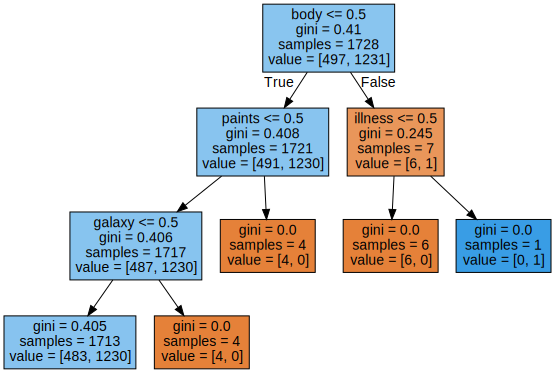

In [ ]:
# Show the tree and it will create a pdf file
visualize_tree(regular_tree_PAP,  regular_vectorizer_PAP, max_depth=5, filename="regular_tree_PAP", file_path=decision_tree_store_path)

* With Hyperparameter Tuning

In [ ]:
param_grid_tree_PAP = {

    # The maximum depth of each decision tree in the ensemble
    'max_depth': [10, 20, 30],

    # Minimum number of samples required to split an internal node
    'min_samples_split': [2, 5, 8],

    # Minimum number of samples required to be at a leaf node
    'min_samples_leaf': [1, 2, 5],

    # The number of features to consider when looking for the best split
    # auto: Considers all features
    # sqrt': Considers the square root of the total number of features
    # log2': Considers the logarithm base 2 of the total number of features
    'max_features': ['auto', 'sqrt', 'log2'],

    # The methods used to measure the quality of a split
    'criterion': ['gini', 'entropy']
}

tune_tree_PAP, tune_vectorizer_PAP, tune_params_PAP = tune_decision_tree(X_train_PAP, y_train_PAP, X_dev_PAP, y_dev_PAP, X_test_PAP, y_test_PAP, param_grid_tree_PAP)

Precision: 0.720
Recall: 1.000
Accuracy: 0.722
AUC: 0.516
Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5}


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


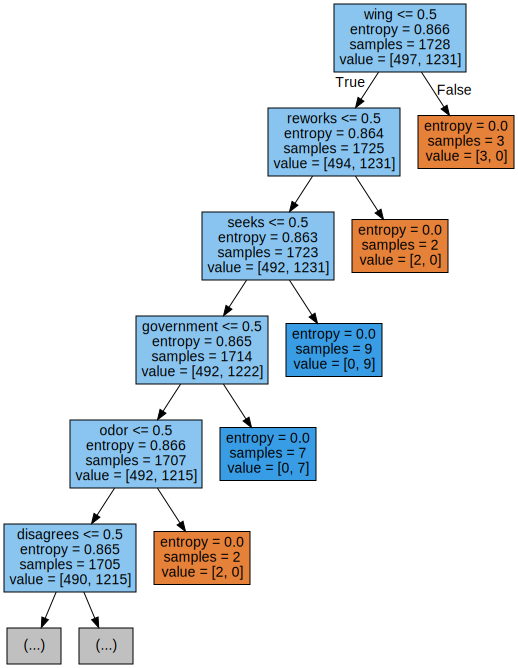

In [ ]:
# Show the tree and it will create a pdf file
visualize_tree(tune_tree_PAP, tune_vectorizer_PAP, max_depth=5, filename = "tune_tree_PAP", file_path = decision_tree_store_path)

## 2.1 In PEP Dataset

* Without Hyperparameter Tuning

In [ ]:
regular_tree_PEP, regular_vectorizer_PEP, regular_results_PEP = regular_decision_tree(X_train_PEP, y_train_PEP, X_test_PEP, y_test_PEP, max_depth=3)


Precision: 0.542
Recall: 0.980
Accuracy: 0.577
AUC: 0.578


* With Hyperparameter Tuning

In [ ]:
param_grid_tree_PEP = {

    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}
tune_tree_PEP, tune_vectorizer_PEP, tune_params_PEP = tune_decision_tree(X_train_PEP, y_train_PEP, X_dev_PEP, y_dev_PEP, X_test_PAP, y_test_PAP,param_grid_tree_PEP)

Precision: 0.703
Recall: 0.922
Accuracy: 0.667
AUC: 0.477
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}


## 2.2 In PEP Dataset, Combined with Binning by Landmark

* Without Hyperparameter Tuning

In [ ]:
def prepare_bow_features(train_data, test_data):
    vectorizer = CountVectorizer()

    X_train_sentences = [' '.join(svo_triplet) for svo_triplet in train_data]
    X_train_vectorized = vectorizer.fit_transform(X_train_sentences)

    X_test_sentences = [' '.join(svo_triplet) for svo_triplet in test_data]
    X_test_vectorized = vectorizer.transform(X_test_sentences)

    return X_train_vectorized, X_test_vectorized, vectorizer

In [ ]:
def train_decision_tree_landmark(X_train_combined, y_train):
    clf = DecisionTreeClassifier()
    clf.fit(X_train_combined, y_train)
    return clf

In [ ]:
def predict_test_data(clf, X_test_combined):
    predictions = clf.predict(X_test_combined)
    return predictions

In [ ]:
def tree_model_evcluation_landmark(X_train_PEP, X_test_PEP, y_train_PEP, y_test_PEP):
    # Prepare Bag-of-Words features
    X_train_bow, X_test_bow, vectorizer = prepare_bow_features(X_train_PEP, X_test_PEP)

    # Transform landmark annotations into features for train and test data
    X_train_features = transform_to_features(X_train_PEP)
    X_test_features = transform_to_features(X_test_PEP)

    # Encode
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

    X_train_array_features = array_features(X_train_features)
    encoder.fit(X_train_array_features)

    X_train_encoded = encoder.transform(X_train_array_features)
    X_test_encoded = encoder.transform(array_features(X_test_features))

    # Combine Bag-of-Words features with landmark annotation features
    X_train_combined = np.hstack((X_train_bow.toarray(), X_train_encoded))
    X_test_combined = np.hstack((X_test_bow.toarray(), X_test_encoded))

    clf = train_decision_tree_landmark(X_train_combined, y_train_PEP)

    predictions = predict_test_data(clf, X_test_combined)

    precision = precision_score(y_test_PEP, predictions, average='binary')
    recall = recall_score(y_test_PEP, predictions, average='binary')
    accuracy = accuracy_score(y_test_PEP, predictions)
    auc = roc_auc_score(y_test_PEP, predictions)

    print(f"Precision: {precision:.3f} / Recall: {recall:.3f} / Accuracy: {accuracy:.3f} / AUC: {auc:.3f}")

    return clf, predictions

In [ ]:
regular_tree_PEP_landmark, regular_predictions_PEP_landmark = tree_model_evcluation_landmark(X_train_PEP, X_test_PEP, y_train_PEP, y_test_PEP)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Precision: 0.785 / Recall: 0.739 / Accuracy: 0.769 / AUC: 0.769


* With Hyperparameter Tuning

In [ ]:
def tune_tree_landmark(X_train_PEP, X_dev_PEP, y_train_PEP, y_dev_PEP, param_grid):

    X_train_bow, X_dev_bow, vectorizer = prepare_bow_features(X_train_PEP, X_dev_PEP)

    X_train_features = transform_to_features(X_train_PEP)
    X_dev_features = transform_to_features(X_dev_PEP)

    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

    X_train_array_features = array_features(X_train_features)
    encoder.fit(X_train_array_features)

    X_train_encoded = encoder.transform(X_train_array_features)
    X_dev_encoded = encoder.transform(array_features(X_dev_features))

    X_train_combined = np.hstack((X_train_bow.toarray(), X_train_encoded))
    X_dev_combined = np.hstack((X_dev_bow.toarray(), X_dev_encoded))

    clf = DecisionTreeClassifier()

    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_combined, y_train_PEP)

    best_clf = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print("Best parameters:", best_params)

    return best_clf, vectorizer, encoder

In [ ]:
def prepare_test_features(X_test_PEP, vectorizer, encoder):

    # Prepare Bag-of-Words features for test set
    X_test_bow = vectorizer.transform([' '.join(svo_triplet) for svo_triplet in X_test_PEP])

    # Transform landmark annotations for test set
    X_test_features = transform_to_features(X_test_PEP)

    # Encode
    X_test_encoded = encoder.transform(array_features(X_test_features))

    return X_test_bow, X_test_encoded

In [ ]:
def evaluate_model_dt_landmark(best_clf, X_test_bow, X_test_encoded, y_test_PEP):

    # Combine Bag-of-Words features with landmark annotation features for test set
    X_test_combined = np.hstack((X_test_bow.toarray(), X_test_encoded))

    # Predict on test set with the best model
    predictions_test = best_clf.predict(X_test_combined)

    # Calculate evaluation metrics on test set
    precision = precision_score(y_test_PEP, predictions_test, average='binary')
    recall = recall_score(y_test_PEP, predictions_test, average='binary')
    accuracy = accuracy_score(y_test_PEP, predictions_test)
    auc = roc_auc_score(y_test_PEP, predictions_test)

    print(f"Precision: {precision:.3f} / Recall: {recall:.3f} / Accuracy: {accuracy:.3f} / AUC: {auc:.3f}")

    return accuracy

In [ ]:
# Tuning hyperparameters on dev set
param_grid_dt_PEP_landmark = {

    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']

    }

tune_tree_PEP_landmark, vectorizer_tune_PEP_landmark, encoder_tune_PEP_landmark = tune_tree_landmark(X_train_PEP, X_dev_PEP, y_train_PEP, y_dev_PEP, param_grid_dt_PEP_landmark)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.w

Best parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}


In [ ]:
# Preprocessing test features
X_test_bow_PEP, X_test_encoded_PEP = prepare_test_features(X_test_PEP,  vectorizer_tune_PEP_landmark, encoder_tune_PEP_landmark)

# Evaluate the model on the test set
dt_tune_Accuracy_PEP_landmark = evaluate_model_dt_landmark(tune_tree_PEP_landmark, X_test_bow_PEP, X_test_encoded_PEP, y_test_PEP)

Precision: 0.789 / Recall: 0.686 / Accuracy: 0.752 / AUC: 0.752


## 3. In ADEPT Dataset

* Without Hyperparameter Tuning

In [ ]:
def evaluate_model_dt_multiclass(X_eval, y_eval, model, vectorizer):
    X_eval_bow = vectorizer.transform(X_eval['text'])
    y_pred = model.predict(X_eval_bow)

    accuracy = accuracy_score(y_eval, y_pred)
    report = classification_report(y_eval, y_pred)
    conf_matrix = confusion_matrix(y_eval, y_pred)

    print(f'Accuracy: {accuracy:.3f}')
    print('Classification in Details:')
    print(report)

    return accuracy, report

In [ ]:
def regular_decision_tree_ADEPT(X_train, y_train, X_eval, y_eval, max_depth=None):
    train_data = preprocess_data(X_train, y_train)
    eval_data = preprocess_data(X_eval, y_eval)

    clf, vectorizer = train_decision_tree(train_data, train_data['label'], max_depth=max_depth)
    eval_results = evaluate_model_dt_multiclass(eval_data, eval_data['label'], clf, vectorizer)

    return clf, vectorizer, eval_results

In [ ]:
regular_tree_ADEPT, regular_vectorizer_ADEPT, regular_results_ADEPT = regular_decision_tree_ADEPT(X_train_ADEPT, y_train_ADEPT, X_test_ADEPT, y_test_ADEPT, max_depth=3)

Accuracy: 0.703
Classification in Details:
              precision    recall  f1-score   support

           0       0.69      0.10      0.17       223
           1       0.42      0.15      0.22       178
           2       0.72      0.98      0.83      1102
           3       0.00      0.00      0.00       102
           4       0.00      0.00      0.00         7

    accuracy                           0.70      1612
   macro avg       0.37      0.25      0.24      1612
weighted avg       0.63      0.70      0.62      1612



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* With Hyperparameter Tuning

In [ ]:
def tune_decision_tree_ADEPT(X_train, y_train, X_dev, y_dev, X_test, y_test, param_grid):
    train_data = preprocess_data(X_train, y_train)
    dev_data = preprocess_data(X_dev, y_dev)
    test_data = preprocess_data(X_test, y_test)

    vectorizer = CountVectorizer()
    X_train_bow = vectorizer.fit_transform(train_data['text'])
    X_dev_bow = vectorizer.transform(dev_data['text'])

    clf = DecisionTreeClassifier()

    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_bow, train_data['label'])

    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_

    best_estimator.fit(X_train_bow, train_data['label'])


    X_test_bow = vectorizer.transform(test_data['text'])
    eval_results = evaluate_model_dt_multiclass(test_data, test_data['label'], best_estimator, vectorizer)
    print("Best Parameters:", best_params)

    return best_estimator, vectorizer, best_params


In [ ]:
param_grid_tree_ADEPT = {
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 8, 10],
    'min_samples_leaf': [1, 5, 8, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}
tune_tree_ADEPT, tune_vectorizer_ADEPT, tune_params_ADEPT = tune_decision_tree_ADEPT(X_train_ADEPT, y_train_ADEPT, X_dev_ADEPT, y_dev_ADEPT, X_test_ADEPT, y_test_ADEPT, param_grid_tree_ADEPT)

Accuracy: 0.702
Classification in Details:
              precision    recall  f1-score   support

           0       0.57      0.14      0.22       223
           1       0.38      0.22      0.28       178
           2       0.73      0.96      0.83      1102
           3       0.00      0.00      0.00       102
           4       0.00      0.00      0.00         7

    accuracy                           0.70      1612
   macro avg       0.34      0.27      0.27      1612
weighted avg       0.62      0.70      0.63      1612

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
